## Setup
---

### Imports
---

In [241]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Data Processing
---

In [242]:
# Import Data
df = pd.read_csv('car_launch_data_5.txt', header=1, delim_whitespace=True)


# Clean data
# Recenter y data; Translate Y data, shift lowest y to 0
m = min(df['y'])
df['y'] = df['y'].apply(lambda x: x-m)

# Make t start at 0
# t_offset = min(df['x'])
# df['t'] = df['t'].apply(lambda x: x-t_offset)

print(df)

        t      x      y
0   0.000  0.132  1.057
1   0.033  0.223  1.140
2   0.067  0.317  1.214
3   0.100  0.411  1.278
4   0.133  0.480  1.319
5   0.167  0.585  1.369
6   0.200  0.678  1.403
7   0.233  0.770  1.425
8   0.267  0.872  1.437
9   0.300  0.938  1.440
10  0.333  1.027  1.432
11  0.367  1.115  1.414
12  0.400  1.201  1.387
13  0.433  1.290  1.343
14  0.467  1.376  1.296
15  0.500  1.461  1.238
16  0.533  1.564  1.152
17  0.567  1.634  1.085
18  0.600  1.715  0.998
19  0.633  1.803  0.891
20  0.667  1.881  0.789
21  0.700  1.957  0.677
22  0.733  2.033  0.557
23  0.767  2.108  0.430
24  0.800  2.181  0.294
25  0.833  2.253  0.150
26  0.867  2.323  0.000


### Initial Plots
---

Text(0.5, 1.0, 'Y vs X position')

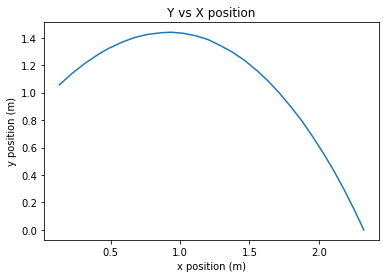

In [243]:
# Initial visualization of the data
plt.plot(df['x'], df['y'])
plt.xlabel("x position (m)")
plt.ylabel("y position (m)")
plt.title("Y vs X position")

Text(0.5, 1.0, 'Y position vs time')

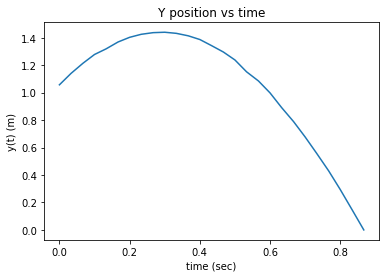

In [244]:
plt.plot(df['t'], df['y'])
plt.xlabel("time (sec)")
plt.ylabel("y(t) (m)")
plt.title("Y position vs time")

Text(0.5, 1.0, 'X position vs time')

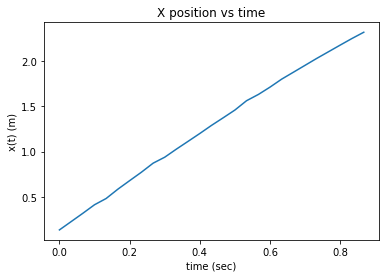

In [245]:
plt.plot(df['t'], df['x'])
plt.xlabel("time (sec)")
plt.ylabel("x(t) (m)")
plt.title("X position vs time")

### Simulation Helpers
---

In [246]:
# Constants
g   = 9.8               # gravity (m/s^2)

t0  = 0                 # initial Time (s) 
dt  = .033              # time resolution

tf  = 0.867             # total time to simulate
nsteps = int(tf/dt) + 1 # number of time steps

# data converted to matrix forms
x_data = df['x'].values
y_data = df['y'].values
t_data = df['t'].values

# Calculate inital conditions based on two given (early) coordinate points
def initial_conditions(coord1, coord2, nsteps):
    t    = coord2[0] - coord1[0]
    x    = coord2[1] - coord1[1]
    y    = coord2[2] - coord1[2]

    return x/t, y/t, coord1[1], coord1[2]


What follows is a helper program that will quickly do plots for us

In [247]:
def make_plot(pars, ftitle, x_err=[], y_err=[], flabel=[], faxis=['']*2, fsize=[6, 4]):
    # this will make sure we don't align labels incorrectly
    if flabel == []:
        flabel = ['']*len(pars)
    

    # create the fig
    fig = plt.figure(figsize=(fsize[0], fsize[1]))

    # loop through to plot all the given lines
    for i in range(len(pars)):
        plt.plot(pars[i][0], pars[i][1], label=flabel[i])

    # handles what to do if errors given
    if not (x_err == []):
        plt.errorbar(pars[0][0], pars[0][1], xerr=x_err,  color='r', linewidth=.5)
    if not (y_err == []):
        plt.errorbar(pars[0][0], pars[0][1], yerr=y_err,  color='r', linewidth=.5)

    # other parameters for the plot
    plt.title(ftitle)
    plt.xlabel(faxis[0])
    plt.ylabel(faxis[1])
    plt.ylim([0, 3])
    plt.legend()

## Euler Method (Algorithm 1)
---

In [248]:
# Euler method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

vx = np.zeros([nsteps])
vy = np.zeros([nsteps])
y  = np.zeros([nsteps])
x  = np.zeros([nsteps])

# Initial Conditions
vx0, vy0, x0, y0          = initial_conditions(df.loc[0], df.loc[1], nsteps)
y[0], x[0], vx[0], vy[0]  = y0, x0, vx0, vy0

print("X vel:", vx0, "m/s")
print("Y vel:", vy0, "m/s")
print("X pos:", x0,  "m")
print("Y pos:", y0,  "m")

## time evolving
for i in range(0, nsteps-1):
    y[i+1]  = y[i] + dt * vy[i]
    vy[i+1] = vy[i] - dt * g

    x[i+1]  = x[i] + dt * vx[i]
    vx[i+1] = vx[i]



X vel: 2.7575757575757573 m/s
Y vel: 2.515151515151514 m/s
X pos: 0.132 m
Y pos: 1.057 m


### Prediction Plots
---

The following are simple prediction VS data plots for the X/Y components and also the total trajectory

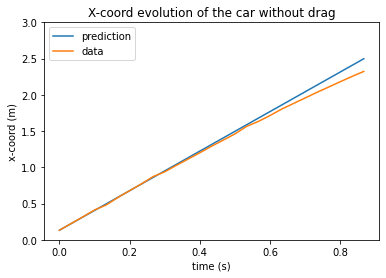

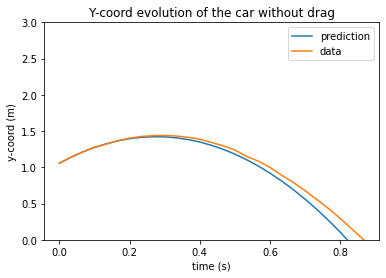

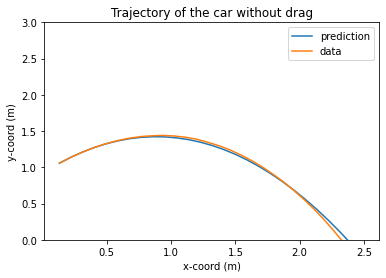

In [249]:
make_plot([[t, x], [t_data, x_data]],
          "X-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "x-coord (m)"])

make_plot([[t, y], [t_data, y_data]],
          "Y-coord evolution of the car without drag",
          flabel=["prediction", "data"],
          faxis=["time (s)", "y-coord (m)"])

make_plot([[x, y], [x_data, y_data]],
          "Trajectory of the car without drag",
          flabel=["prediction", "data"],
          faxis=["x-coord (m)", "y-coord (m)"])

## Error
---

Now we can calculate the average error against the data. This will likely be most largely influenced by the air resistance, so we anticipate the error to grow (linearly) over time.

In [250]:
# the error function here just calculates the point per point percentage error
def err(actual, expected):
    if not len(actual) == len(expected):
        return "number of data points do not match"
    else:
        return [round(abs(actual[i] - expected[i]), 5) if actual[i] > 0 and expected[i] > 0 else 0 for i in range(len(actual)) ]

### Error Plots - Euler vs Continuous Distribution
---

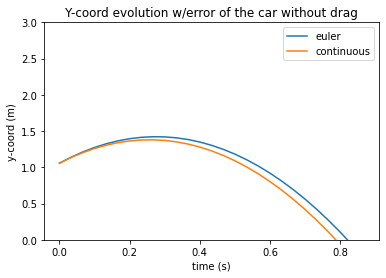

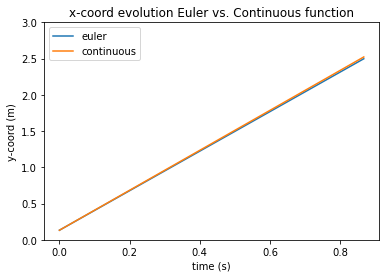

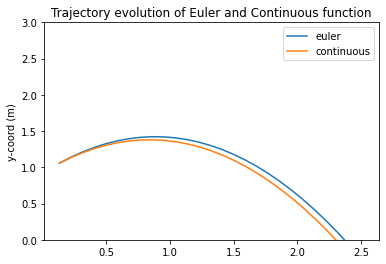

In [251]:
# we initialize a new range for the equations, and calculate the paths directly
# a = np.arange(0, 0.85, 0.001)
a = t
b = y0 + vy0 * a - (1/2) * g * a**2
c = x0 + vx0 * a

# plots
make_plot([[t, y], [a, b]],
          "Y-coord evolution w/error of the car without drag",
          flabel=["euler", "continuous"],
          faxis=["time (s)", "y-coord (m)"])

make_plot([[t, x], [a, c]],
          "x-coord evolution Euler vs. Continuous function",
          flabel=["euler", "continuous"],
          faxis=["time (s)", "y-coord (m)"])
          
make_plot([[x, y], [c, b]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["euler", "continuous"],
          faxis=["", "y-coord (m)"])


The error shown above feels rather large, perhaps not in the x, but certainly it is large in the y. I think it may look more skewed than it is due to the small numbers involved (ie less than a meter in vertical distances), however something feels wrong here.

We will see if other methods can do better

## Bashforth-Adams (Algorithm 2)
---

The bashforth-adams algorithm is apparently an improvement on the Euler
algorithm so we will make an attempt at comparing them here

For a given position component, we have: <br>
$$ y_{n+1} = y_n + \frac{3}{2} \delta t f\left(t_n,y_n\right) - \frac{1}{2} \delta t f\left(t_{n-1},y_{n-1}\right)$$

Here the function $f$ is the derivative of the position component in question, thus we will be initializing it as the velocity.

In [252]:
# Bashforth-Adams method setting up - time evolution
t = np.linspace(t0, tf, nsteps)

# BA Initial Conditions
vy_ba = np.zeros([nsteps])
vx_ba = np.zeros([nsteps])
y_ba  = np.zeros([nsteps])
x_ba  = np.zeros([nsteps])

# Initial Conditions
vx0, vy0, x0, y0    = initial_conditions(df.loc[0], df.loc[1], nsteps)
vx1, vy1, x1, y1    = initial_conditions(df.loc[1], df.loc[2], nsteps)
y_ba[0], x_ba[0], vx_ba[0], vy_ba[0]  = y0, x0, vx0, vy0
y_ba[1], x_ba[1], vx_ba[1], vy_ba[1]  = y1, x1, vx1, vy1

In [253]:
# Time evolving
for i in range(0, nsteps-2):
    y_ba[i+2]  = y_ba[i+1] + dt * (3/2*vy_ba[i+1] - 1/2*vy_ba[i])
    vy_ba[i+2] = vy_ba[i+1] - dt * g

    x_ba[i+2]  = x_ba[i+1] + dt * (3/2*vx_ba[i+1] - 1/2*vx_ba[i])
    vx_ba[i+2] = vx_ba[i]


### Prediction Plots
---

These are the BA plots agains data. We can see that air resistance is still cuasing some pronounced effects.

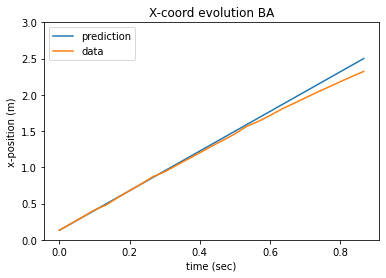

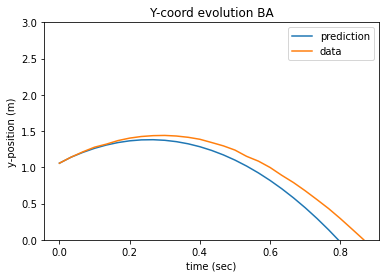

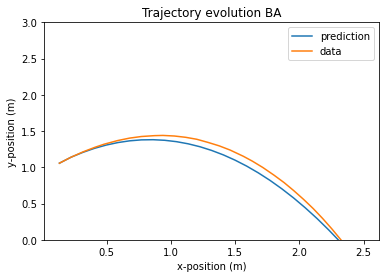

In [254]:
make_plot([[t, x_ba], [t_data, x_data]],       # data plotting (pars)
          "X-coord evolution BA",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "x-position (m)"])
        
make_plot([[t, y_ba], [t_data, y_data]],       # data plotting (pars)
          "Y-coord evolution BA",
          flabel=["prediction", "data"],
          faxis=["time (sec)", "y-position (m)"])

make_plot([[x_ba, y_ba], [x_data, y_data]],       # data plotting (pars)
          "Trajectory evolution BA",
          flabel=["prediction", "data"],
          faxis=["x-position (m)", "y-position (m)"])

### Error Plots - BA vs Continuous Plot
---

[0.0, 0.00095, 0.00156, 0.00263, 0.00323, 0.0043, 0.0049, 0.00598, 0.00658, 0.00765, 0.00825, 0.00932, 0.00993, 0.011, 0.0116, 0.01267, 0.01327, 0.01434, 0.01495, 0.01602, 0.01662, 0.01769, 0.01829, 0.01937, 0.01997, 0.02104, 0.02164]
[0.0, 0.00458, 0.00329, 0.00248, 0.00189, 0.00153, 0.00139, 0.00148, 0.00179, 0.00233, 0.00309, 0.00408, 0.00529, 0.00673, 0.0084, 0.01028, 0.0124, 0.01474, 0.0173, 0.02009, 0.0231, 0.02634, 0.02981, 0.0335, 0, 0, 0]


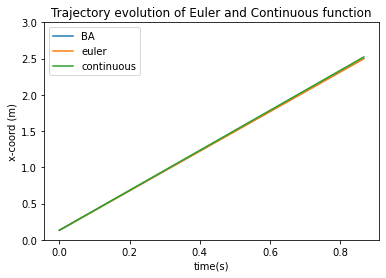

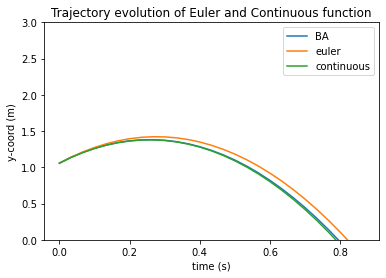

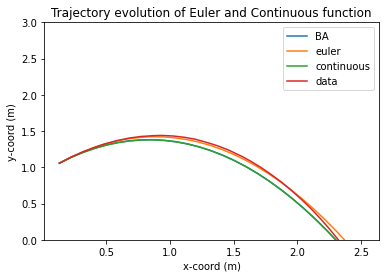

In [255]:
# errors
x_err_ba = err(x_ba, c)
y_err_ba = err(y_ba, b)
print(x_err_ba)
print(y_err_ba)

# plots
make_plot([[t, x_ba], [t, x], [a, c]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous" ],
          faxis=["time(s)", "x-coord (m)"])

make_plot([[t, y_ba], [t, y], [a, b]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous" ],
          faxis=["time (s)", "y-coord (m)"])
          
make_plot([[x_ba, y_ba], [x, y], [c, b], [x_data, y_data]],
          "Trajectory evolution of Euler and Continuous function",
          flabel=["BA", "euler", "continuous", "data" ],
          faxis=["x-coord (m)", "y-coord (m)"])

BA does in fact seem to be in better agreement with the continuous distribution

We will see whether or not Runge-Kutta will do any better

## Runge-Kutta (Algorithm 3)
---